# Import Library
import library

In [206]:
!pip install tensorflow
import seaborn as sns
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import csv
import matplotlib.pyplot as plt

In [207]:
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


# Import Training set and Test set of Titanic Survival

In [208]:
whole_train_set = pd.read_csv('train.csv')
whole_test_set = pd.read_csv('test.csv')

print('shape of train set :',whole_train_set.shape)
print('shape of test set:', whole_test_set.shape)

print('Die rate :', round(np.mean(whole_train_set['Survived'])*100,2), '%')

print(' ---- Null data in train set : ----\n', whole_train_set.isnull().sum())
print(' ---- Null data in test set : ----\n', whole_test_set.isnull().sum())

print(whole_train_set.loc[range(20)])

shape of train set : (891, 12)
shape of test set: (418, 11)
Die rate : 38.38 %
 ---- Null data in train set : ----
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
 ---- Null data in test set : ----
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
    PassengerId  Survived  Pclass  \
0             1         0       3   
1             2         1       1   
2             3         1       3   
3             4         1       1   
4             5         0       3   
5             6         0       3   
6             7         0       1   
7             8         0       3   
8             9         1       3   
9            10

# Cleanse Data

In [209]:
# drop name and ID (These features are unique for every person)
drop_col = ['Name', 'PassengerId']
train_set = whole_train_set.drop(drop_col, axis = 1)
test_set = whole_test_set.drop(drop_col, axis = 1)
print(train_set)

     Survived  Pclass     Sex   Age  SibSp  Parch            Ticket      Fare  \
0           0       3    male  22.0      1      0         A/5 21171    7.2500   
1           1       1  female  38.0      1      0          PC 17599   71.2833   
2           1       3  female  26.0      0      0  STON/O2. 3101282    7.9250   
3           1       1  female  35.0      1      0            113803   53.1000   
4           0       3    male  35.0      0      0            373450    8.0500   
5           0       3    male   NaN      0      0            330877    8.4583   
6           0       1    male  54.0      0      0             17463   51.8625   
7           0       3    male   2.0      3      1            349909   21.0750   
8           1       3  female  27.0      0      2            347742   11.1333   
9           1       2  female  14.0      1      0            237736   30.0708   
10          1       3  female   4.0      1      1           PP 9549   16.7000   
11          1       1  femal

Age features is null about 25%, so this feature should be drop or replace with some values.


In [210]:
%matplotlib inline
# 1 plot age drop null
age_plot = train_set.loc[np.logical_not(train_set['Age'].isnull()), ['Age']]
#sns.distplot(age_plot, bins = 50, axlabel = 'Age drop null', color="r")

# 2 correlation of age vs survival
age_sur = train_set.loc[np.logical_not(train_set['Age'].isnull()) ,'Age'].corr(train_set.loc[np.logical_not(train_set['Age'].isnull()) ,'Survived'])
print(age_sur)

# 3 drop age
train_set = train_set.drop(['Age'], axis = 1)
test_set = test_set.drop(['Age'], axis = 1)

-0.0772210945722


In [211]:
# Find distinct values for categorical features
choose_elements = ['Embarked', 'Ticket', 'Cabin', 'Parch']
train_set_copy = train_set.copy()
train_set_copy = train_set_copy[choose_elements]

In [212]:
## Deal with Cabin features -> change string feature to numeric feature
# step 1 change null in column to N (no cabin)
train_set.loc[train_set['Cabin'].isnull(), 'Cabin'] = 'N'
test_set.loc[test_set['Cabin'].isnull(), 'Cabin'] = 'N'

# step 2 change cabin type to abbreviate type (neglect number of cabin)
train_set.loc[:, 'Cabin'] = train_set.loc[:, 'Cabin'].map(lambda x: str(x)[0])
test_set.loc[:, 'Cabin'] = test_set.loc[:, 'Cabin'].map(lambda x: str(x)[0])

# step 3 identify unique value for cabin features
print('Unique Value for featured Cabin :',train_set['Cabin'].unique())

# step 4 replace categorical with features
dic_cabin = {'N':0, 'C':1, 'E':2, 'G':3, 'D':4, 'A':5, 'B':6, 'F':7, 'T':8}
train_set['Cabin_Numeric'] = train_set['Cabin'].map(dic_cabin)
test_set['Cabin_Numeric'] = test_set['Cabin'].map(dic_cabin)

# step 5 drop cabin
train_set = train_set.drop(['Cabin'], axis = 1)
test_set = test_set.drop(['Cabin'], axis = 1)

print(test_set)

Unique Value for featured Cabin : ['N' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
     Pclass     Sex  SibSp  Parch              Ticket      Fare Embarked  \
0         3    male      0      0              330911    7.8292        Q   
1         3  female      1      0              363272    7.0000        S   
2         2    male      0      0              240276    9.6875        Q   
3         3    male      0      0              315154    8.6625        S   
4         3  female      1      1             3101298   12.2875        S   
5         3    male      0      0                7538    9.2250        S   
6         3  female      0      0              330972    7.6292        Q   
7         2    male      1      1              248738   29.0000        S   
8         3  female      0      0                2657    7.2292        C   
9         3    male      2      0           A/4 48871   24.1500        S   
10        3    male      0      0              349220    7.8958        S   
11        1    m

In [213]:
## Deal with embarked features -> change embark feature to numerical
# step 1 convert null value to unknown
train_set.loc[train_set['Embarked'].isnull(),'Embarked'] = 'unknown'
test_set.loc[test_set['Embarked'].isnull(),'Embarked'] = 'unknown'

# step 2 convert string to numeric value
dic_embarked = {'S':0, 'C':1, 'Q':2, 'unknown':3}
train_set['Embarked_Numeric'] = train_set['Embarked'].map(dic_embarked)
test_set['Embarked_Numeric'] = test_set['Embarked'].map(dic_embarked)

# step 3 drop embarked feature
train_set = train_set.drop(['Embarked'], axis = 1)
test_set = test_set.drop(['Embarked'], axis = 1)

print(test_set)


     Pclass     Sex  SibSp  Parch              Ticket      Fare  \
0         3    male      0      0              330911    7.8292   
1         3  female      1      0              363272    7.0000   
2         2    male      0      0              240276    9.6875   
3         3    male      0      0              315154    8.6625   
4         3  female      1      1             3101298   12.2875   
5         3    male      0      0                7538    9.2250   
6         3  female      0      0              330972    7.6292   
7         2    male      1      1              248738   29.0000   
8         3  female      0      0                2657    7.2292   
9         3    male      2      0           A/4 48871   24.1500   
10        3    male      0      0              349220    7.8958   
11        1    male      0      0                 694   26.0000   
12        1  female      1      0               21228   82.2667   
13        2    male      1      0               24065   26.000

In [214]:
## Deal with sex features
# convert string to numeric value
dic_sex = {'male':0, 'female':1}
train_set['Sex_Numeric'] = train_set['Sex'].map(dic_sex)
test_set['Sex_Numeric'] = train_set['Sex'].map(dic_sex)

# drop sex features
train_set = train_set.drop(['Sex'], axis = 1)
test_set = test_set.drop(['Sex'], axis = 1)
print(train_set)

     Survived  Pclass  SibSp  Parch            Ticket      Fare  \
0           0       3      1      0         A/5 21171    7.2500   
1           1       1      1      0          PC 17599   71.2833   
2           1       3      0      0  STON/O2. 3101282    7.9250   
3           1       1      1      0            113803   53.1000   
4           0       3      0      0            373450    8.0500   
5           0       3      0      0            330877    8.4583   
6           0       1      0      0             17463   51.8625   
7           0       3      3      1            349909   21.0750   
8           1       3      0      2            347742   11.1333   
9           1       2      1      0            237736   30.0708   
10          1       3      1      1           PP 9549   16.7000   
11          1       1      0      0            113783   26.5500   
12          0       3      0      0         A/5. 2151    8.0500   
13          0       3      1      5            347082   31.275

In [215]:
## Deal with Ticket features
# drop Ticket feature
train_set = train_set.drop(['Ticket'], axis = 1)
test_set = test_set.drop(['Ticket'], axis = 1)

print(test_set)

     Pclass  SibSp  Parch      Fare  Cabin_Numeric  Embarked_Numeric  \
0         3      0      0    7.8292              0                 2   
1         3      1      0    7.0000              0                 0   
2         2      0      0    9.6875              0                 2   
3         3      0      0    8.6625              0                 0   
4         3      1      1   12.2875              0                 0   
5         3      0      0    9.2250              0                 0   
6         3      0      0    7.6292              0                 2   
7         2      1      1   29.0000              0                 0   
8         3      0      0    7.2292              0                 1   
9         3      2      0   24.1500              0                 0   
10        3      0      0    7.8958              0                 0   
11        1      0      0   26.0000              0                 0   
12        1      1      0   82.2667              6              

In [216]:
## Deal with name features (extract Mr, Mrs or Sir from the name)

# for train set
name_split = whole_train_set['Name'].map(lambda x: x.split(','))
name_split_temp = name_split.map(lambda x: x[1].split('.'))
train_abb_name = name_split_temp.map(lambda x: x[0])
train_abb_name_unique = train_abb_name.unique()


# for test set
name_split = whole_test_set['Name'].map(lambda x: x.split(','))
name_split_temp = name_split.map(lambda x: x[1].split('.'))
test_abb_name = name_split_temp.map(lambda x: x[0])
test_abb_name_unique = test_abb_name.unique()

# create convert dict
dict_mr = {}
for i, col in enumerate(train_abb_name_unique):
    dict_mr[col] = int(i)
print(dict_mr)

train_abb_name_numeric = train_abb_name.map(dict_mr)
test_abb_name_numeric = test_abb_name.map(dict_mr)

train_set['Name_Numeric'] = train_abb_name_numeric
test_abb_name_numeric[test_abb_name_numeric.isnull()] = 0 
test_abb_name_numeric = test_abb_name_numeric.map(lambda x : int(x))
test_set['Name_Numeric'] = test_abb_name_numeric

print(test_set['Name_Numeric'])

{' Mr': 0, ' Mrs': 1, ' Miss': 2, ' Master': 3, ' Don': 4, ' Rev': 5, ' Dr': 6, ' Mme': 7, ' Ms': 8, ' Major': 9, ' Lady': 10, ' Sir': 11, ' Mlle': 12, ' Col': 13, ' Capt': 14, ' the Countess': 15, ' Jonkheer': 16}
0      0
1      1
2      0
3      0
4      1
5      0
6      2
7      0
8      1
9      0
10     0
11     0
12     1
13     0
14     1
15     1
16     0
17     0
18     2
19     1
20     0
21     3
22     1
23     0
24     1
25     0
26     2
27     0
28     0
29     0
      ..
388    0
389    3
390    0
391    1
392    3
393    0
394    0
395    1
396    0
397    1
398    0
399    0
400    2
401    0
402    2
403    0
404    0
405    0
406    0
407    0
408    2
409    2
410    2
411    1
412    2
413    0
414    0
415    0
416    0
417    3
Name: Name_Numeric, Length: 418, dtype: int64


# Visualize features

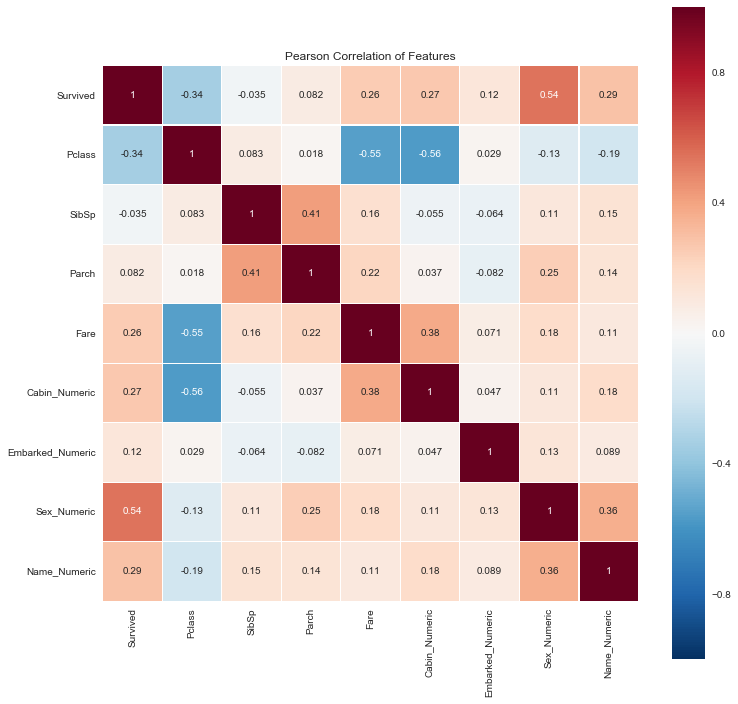

In [217]:
# Visualize correlation of each features
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(train_set.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

Survived
Survived Min : 0.00, Max : 1.00, Mean : 0.38, Median : 0.00, Std : 0.49
Pclass
Pclass Min : 1.00, Max : 3.00, Mean : 2.31, Median : 3.00, Std : 0.84
SibSp
SibSp Min : 0.00, Max : 8.00, Mean : 0.52, Median : 0.00, Std : 1.10
Parch
Parch Min : 0.00, Max : 6.00, Mean : 0.38, Median : 0.00, Std : 0.81
Fare
Fare Min : 0.00, Max : 512.33, Mean : 32.20, Median : 14.45, Std : 49.67
Cabin_Numeric
Cabin_Numeric Min : 0.00, Max : 8.00, Mean : 0.81, Median : 0.00, Std : 1.81
Embarked_Numeric
Embarked_Numeric Min : 0.00, Max : 3.00, Mean : 0.37, Median : 0.00, Std : 0.65
Sex_Numeric
Sex_Numeric Min : 0.00, Max : 1.00, Mean : 0.35, Median : 0.00, Std : 0.48
Name_Numeric
Name_Numeric Min : 0.00, Max : 16.00, Mean : 0.94, Median : 0.00, Std : 1.72


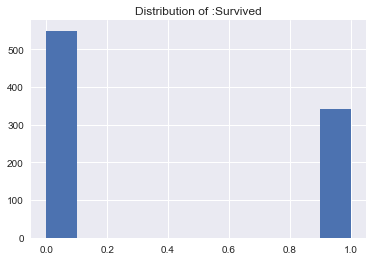

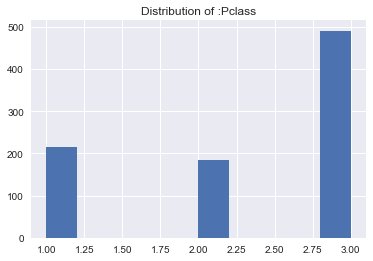

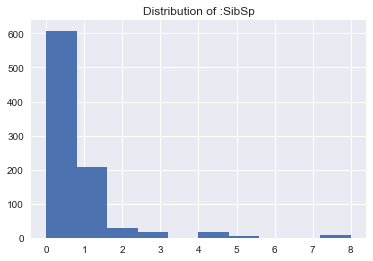

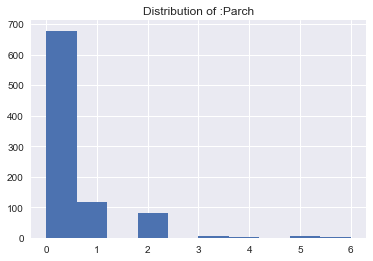

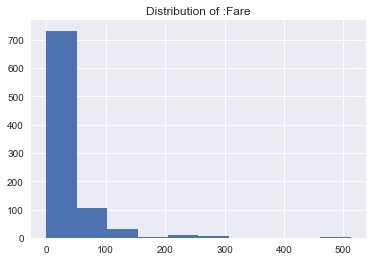

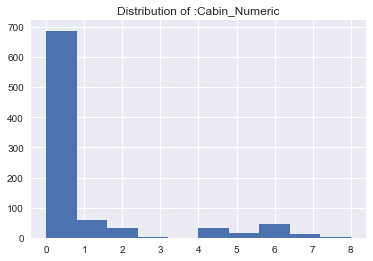

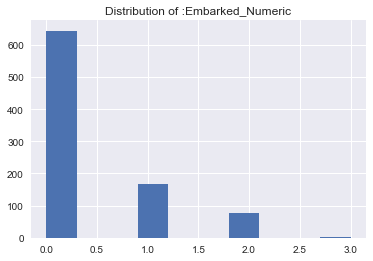

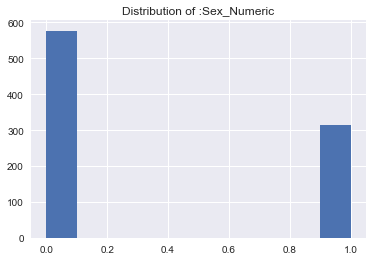

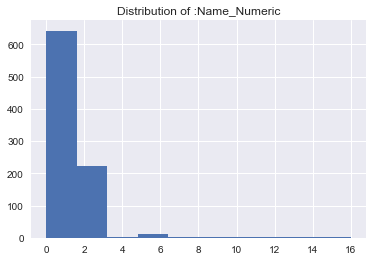

In [218]:
## visualize distribution of each features

col_interest = ['Fare', 'SibSp', 'Parch']

def r2(x): return round(x,2)

for col in list(train_set):
    fig = plt.figure()
    ax1 = fig.gca()
    
    print(col)
    plt.hist(train_set[col])
    print('{:s} Min : {:.2f}, Max : {:.2f}, Mean : {:.2f}, Median : {:.2f}, Std : {:.2f}'.format
          (col, np.min(train_set[col]), np.max(train_set[col]), np.mean(train_set[col])
          , np.median(train_set[col]), np.std(train_set[col])))
    plt.title('Distribution of :' + col)

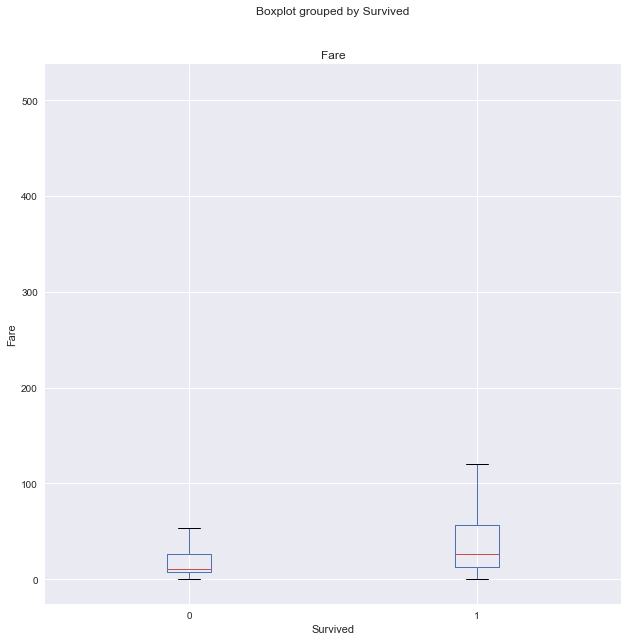

In [219]:
## visualize box plot

col_interest = ['Fare']
for col in col_interest:
    fig = plt.figure()
    train_set.boxplot(column = col, by = ['Survived'], figsize = (10,10))
    plt.xlabel('Survived')
    plt.ylabel(col)

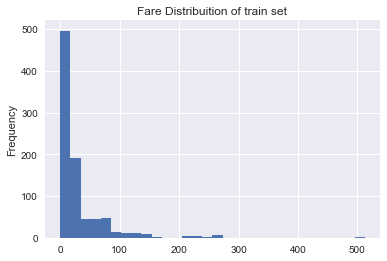

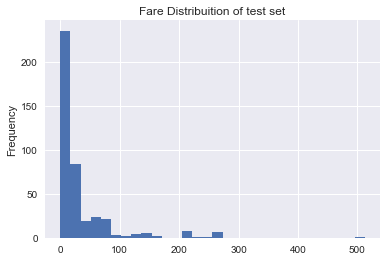

In [220]:
## Visualize histogram plot

fig = plt.figure()
train_set['Fare'].plot.hist(bins = 30)
plt.title('Fare Distribuition of train set')

fig = plt.figure()
test_set['Fare'].plot.hist(bins = 30)
plt.title('Fare Distribuition of test set')

dead
 0    468
1     81
Name: Sex_Numeric, dtype: int64
survived
 0    109
1    233
Name: Sex_Numeric, dtype: int64
0    549
Name: Survived, dtype: int64


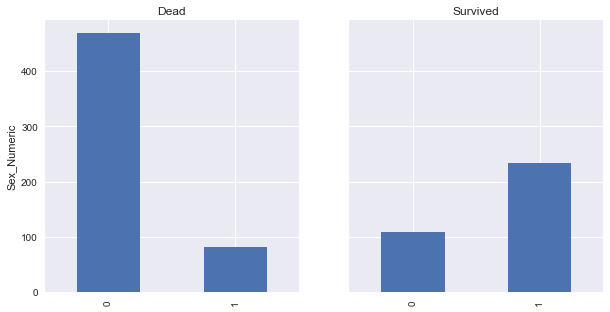

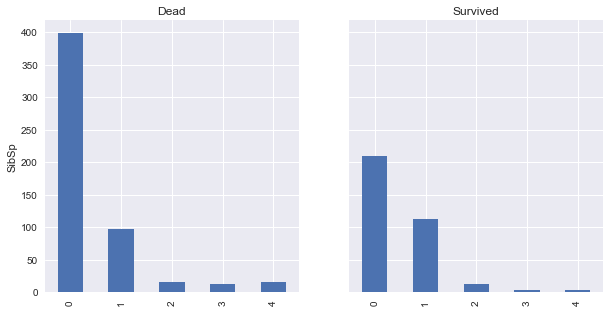

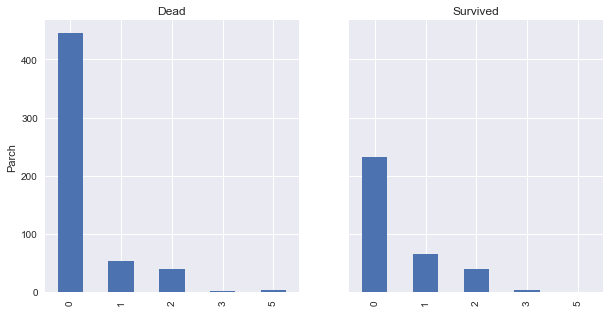

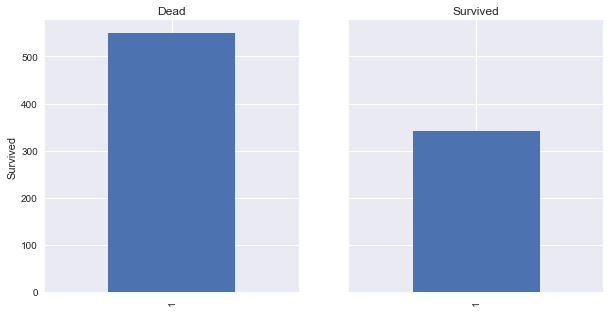

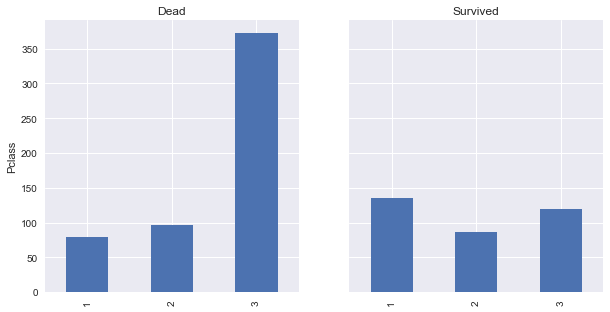

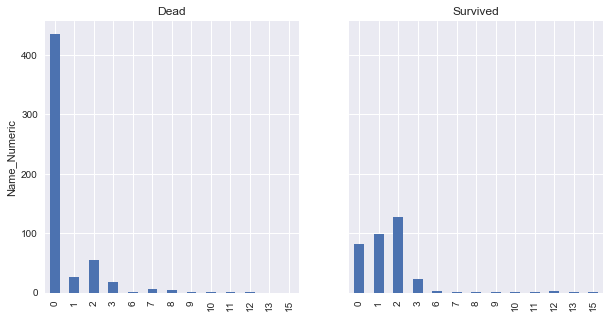

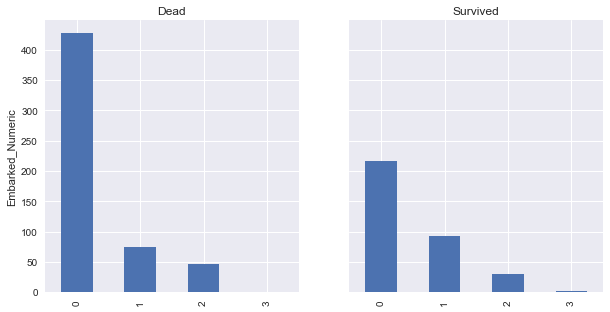

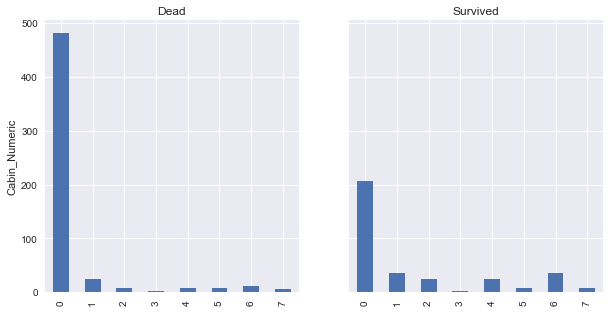

In [221]:
## Visualize barplot group by survived

print('dead\n', train_set.loc[train_set['Survived'] == 0, 'Sex_Numeric'].value_counts(sort = False))
print('survived\n', train_set.loc[train_set['Survived'] == 1, 'Sex_Numeric'].value_counts(sort = False))

for col in set(list(train_set)) - set(['Fare']):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex = True, sharey = True)
    train_set.loc[train_set['Survived'] == 0, col].value_counts(sort = False).plot(kind = 'bar', ax = ax1)
    ax1.set_title('Dead')
    train_set.loc[train_set['Survived'] == 1, col].value_counts(sort = False).plot(kind = 'bar', ax = ax2)
    ax2.set_title('Survived')
    ax1.set_ylabel(col)
    
print(train_set.loc[train_set['Survived'] == 0, 'Survived'].value_counts())


0    549
Name: Survived, dtype: int64


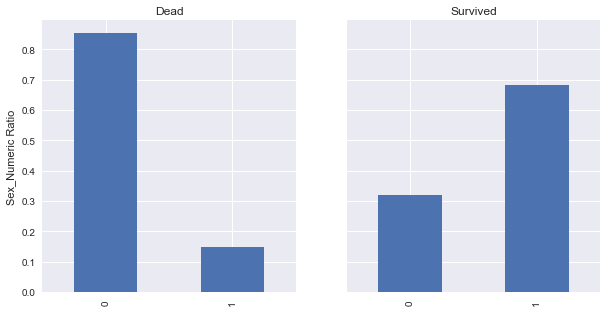

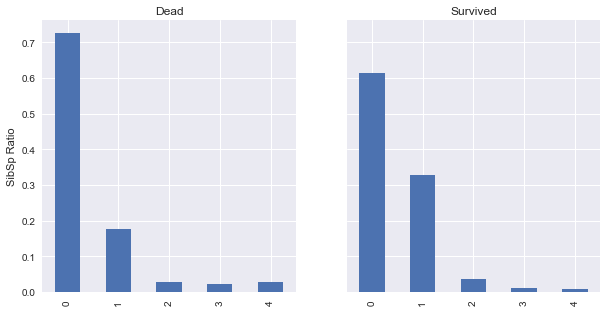

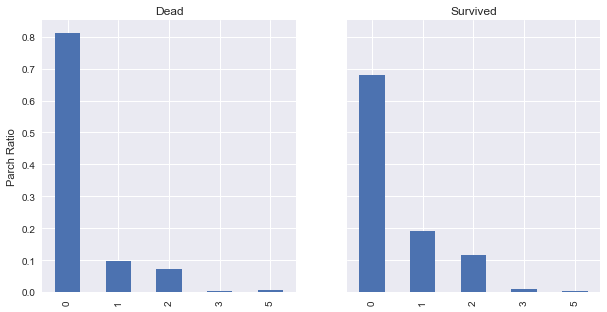

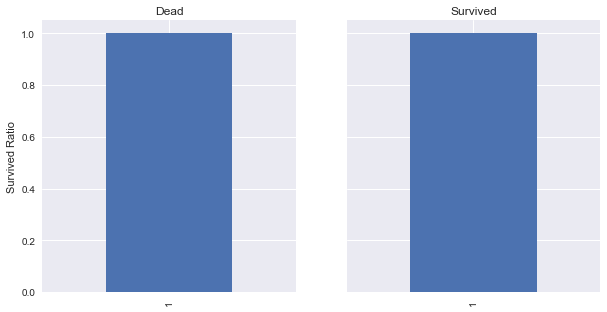

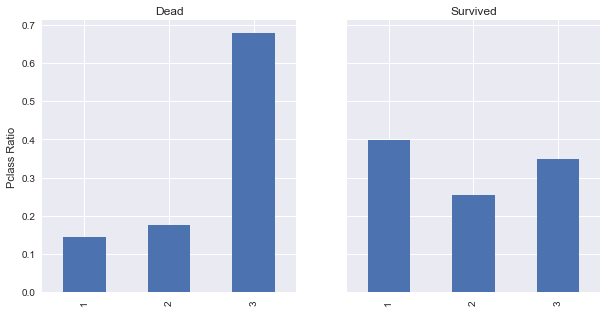

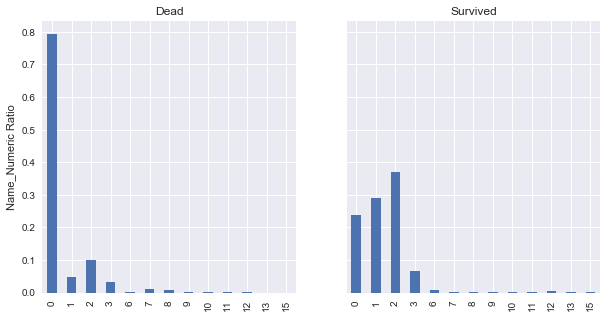

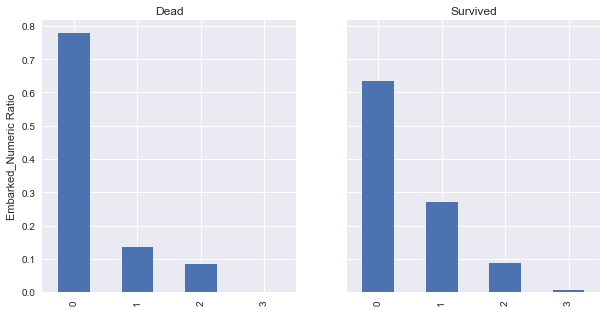

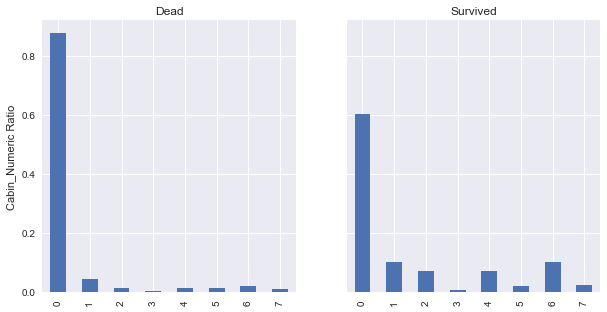

In [222]:
## Visualize barplot group by survived and divide by number of survival 
# to observe each category in normalize way

num_survive = len(train_set.loc[train_set['Survived'] == 1, 'Survived'])
num_notsurvive = len(train_set.loc[train_set['Survived'] == 0, 'Survived'])
for col in set(list(train_set)) - set(['Fare']):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex = True, sharey = True)
    (train_set.loc[train_set['Survived'] == 0, col].value_counts(sort = False)/num_notsurvive).plot(kind = 'bar', ax = ax1)
    ax1.set_title('Dead')
    (train_set.loc[train_set['Survived'] == 1, col].value_counts(sort = False)/num_survive).plot(kind = 'bar', ax = ax2)
    ax2.set_title('Survived')
    ax1.set_ylabel(col + ' Ratio')
    
print(train_set.loc[train_set['Survived'] == 0, 'Survived'].value_counts())


# Transform Categorical data to indicator data

In [223]:
## Transform All categorical data to indicator data

train_data_copy = train_set.copy()
test_data_copy = test_set.copy()
for col in set(list(train_set)) - set(['Fare', 'Survived']):
    train_data_copy = pd.get_dummies(train_data_copy, columns = [col])
    test_data_copy = pd.get_dummies(test_data_copy, columns = [col])

col_train = list(train_data_copy)
col_test = list(test_data_copy)
    
for col in set(col_train) - set(['Survived']):
    if col not in col_test:
        test_data_copy[col] = np.zeros(test_data_copy[col_test[0]].shape[0])

for col in list(test_data_copy):
    if col not in list(train_data_copy):
        train_data_copy[col] = np.zeros(train_data_copy[col_train[0]].shape[0])
print(train_data_copy)
print(test_data_copy)


     Survived      Fare  Pclass_1  Pclass_2  Pclass_3  Name_Numeric_0  \
0           0    7.2500         0         0         1               1   
1           1   71.2833         1         0         0               0   
2           1    7.9250         0         0         1               0   
3           1   53.1000         1         0         0               0   
4           0    8.0500         0         0         1               1   
5           0    8.4583         0         0         1               1   
6           0   51.8625         1         0         0               1   
7           0   21.0750         0         0         1               0   
8           1   11.1333         0         0         1               0   
9           1   30.0708         0         1         0               0   
10          1   16.7000         0         0         1               0   
11          1   26.5500         1         0         0               0   
12          0    8.0500         0         0        

# Log transformation 

Fare                  0
Pclass_1              0
Pclass_2              0
Pclass_3              0
Name_Numeric_0        0
Name_Numeric_1        0
Name_Numeric_2        0
Name_Numeric_3        0
Name_Numeric_5        0
Name_Numeric_6        0
Name_Numeric_8        0
Name_Numeric_13       0
Sex_Numeric_0         0
Sex_Numeric_1         0
SibSp_0               0
SibSp_1               0
SibSp_2               0
SibSp_3               0
SibSp_4               0
SibSp_5               0
SibSp_8               0
Parch_0               0
Parch_1               0
Parch_2               0
Parch_3               0
Parch_4               0
Parch_5               0
Parch_6               0
Parch_9               0
Embarked_Numeric_0    0
Embarked_Numeric_1    0
Embarked_Numeric_2    0
Cabin_Numeric_0       0
Cabin_Numeric_1       0
Cabin_Numeric_2       0
Cabin_Numeric_3       0
Cabin_Numeric_4       0
Cabin_Numeric_5       0
Cabin_Numeric_6       0
Cabin_Numeric_7       0
Name_Numeric_11       0
Embarked_Numeric

'\nplot_train = train_data_copy.copy()\nplot_test = test_data_copy.copy()\n'

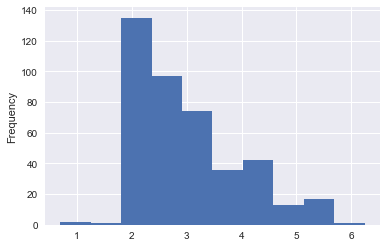

In [224]:
## Transform exponential like distribution of Fare to Normal distribution
## using box-cox transformation

#train_data_copy.loc[np.logical_not(train_data_copy['Fare'].isnull()), 'Fare'].plot.hist(bins = 20)

med = np.median(test_data_copy.loc[np.logical_not(test_data_copy['Fare'].isnull()),'Fare'])
test_data_copy.loc[test_data_copy['Fare'].isnull(), 'Fare'] = med
print(test_data_copy.isnull().sum())


plot_train = train_data_copy.copy()
plot_test = test_data_copy.copy()
small_nonzero = np.min(plot_train.loc[plot_train['Fare'] > 0,'Fare'])

lamb_1 = 2
plot_train['Fare'] = plot_train['Fare'].apply(lambda x : np.log(x + lamb_1))
plot_test['Fare'] = plot_test['Fare'].apply(lambda x : np.log(x + lamb_1))


plot_test.loc[np.logical_not(plot_test['Fare'].isnull()), 'Fare'].plot.hist(bins = 10)

'''
plot_train = train_data_copy.copy()
plot_test = test_data_copy.copy()
'''

In [225]:
## sort feature of each set to make sure they are in right order

plot_train.sort_index(axis=1, inplace=True)
plot_test.sort_index(axis = 1, inplace = True)
print(plot_train.Fare)

0      2.224624
1      4.294333
2      2.295057
3      4.009150
4      2.307573
5      2.347396
6      3.986435
7      3.138750
8      2.575151
9      3.467946
10     2.928524
11     3.351657
12     2.307573
13     3.504806
14     2.287898
15     2.890372
16     3.438011
17     2.708050
18     2.995732
19     2.221917
20     3.332205
21     2.708050
22     2.305501
23     3.624341
24     3.138750
25     3.508182
26     2.221917
27     5.579730
28     2.290432
29     2.292110
         ...   
861    2.602690
862    3.329673
863    4.270397
864    2.708050
865    2.708050
866    2.763693
867    3.960733
868    2.442347
869    2.575151
870    2.292110
871    3.999195
872    1.945910
873    2.397895
874    3.258097
875    2.221917
876    2.471973
877    2.292110
878    2.292110
879    4.444512
880    3.332205
881    2.292110
882    2.527064
883    2.525729
884    2.202765
885    3.438011
886    2.708050
887    3.465736
888    3.236716
889    3.465736
890    2.277267
Name: Fare, Length: 891,

# Deep Learning NN
N-layer NN are used to learn survival of passenger.

In [226]:
## create x_train, x_test and y_train
train_set_feature = plot_train.drop(['Survived'], axis = 1) # drop label output
for col in ['Fare']:
    print(col)
    plot_test[col] = (plot_test[col]- np.mean(train_set_feature[col]))/np.std(train_set_feature[col])
    mean = np.mean(train_set_feature[col])
    std = np.std(train_set_feature[col])
    train_set_feature[col] = (train_set_feature[col] - mean)/std

x_train = train_set_feature.as_matrix().T
x_test = plot_test.as_matrix().T

y_train = train_data_copy['Survived'].as_matrix().T
y_train = y_train.reshape(1, len(y_train))

print('Shape of X for train', x_train.shape)
print('Shape of Y for train', y_train.shape)
print('Shape of X for test', x_test.shape)
#print(test_set)
print(x_train)

Fare
Shape of X for train (51, 891)
Shape of Y for train (1, 891)
Shape of X for test (51, 418)
[[ 1.  0.  1. ...,  1.  0.  1.]
 [ 0.  1.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


# Create Place Holders (Input, Output)
Create method for crate place holder

In [227]:
# place holders

def create_placeholders(n_x, n_y):
    '''
    Creates place holders for TensorFlow session (Place holders is a variable that can be update during sessions)
    
    Arguments:
    n_x = Number of input features
    n_y = Number of label outputs
    
    Return:
    X = placeholders for input
    Y = labels for output
    '''
    
    X = tf.placeholder(tf.float32, shape = (n_x, None), name = 'X')
    Y = tf.placeholder(tf.float32, shape = (n_y, None), name = 'Y')
    
    return X, Y

In [228]:
# Unit test
X, Y = create_placeholders(7, 1)
print('X =', X)
print('Y =', Y)

X = Tensor("X_3:0", shape=(7, ?), dtype=float32)
Y = Tensor("Y_3:0", shape=(1, ?), dtype=float32)


# Create Initializing parameters method

In [229]:
# create initializing parameters 

def initialize_parameters_deep(layers_dim, scale_l2):
    '''
    Create and initialize parameters according to number of hidden neuron in each layers.
    
    Arguments:
    layer_dim = vector of number of hidden neuron in each layer, eg. [n_x, 5, 3, n_y] 
    
    Return:
    parameters = dictionary of tensor variables w and b
    '''
    
    parameters = {}
        
    tf.set_random_seed(1)
    num_all_layers = len(layers_dim)

    for i in range(num_all_layers-1):
        
        parameters['W'+str(i+1)] = tf.get_variable('W' + str(i+1), [layers_dim[i+1], layers_dim[i]],
                                                   initializer = tf.contrib.layers.xavier_initializer(seed = i))
        parameters['b'+str(i+1)] = tf.get_variable('b' + str(i+1), [layers_dim[i+1], 1], initializer = tf.zeros_initializer())
        
        # sum of all weight to compute regularization
        if i == 0:
            sum_w = tf.nn.l2_loss(parameters['W'+str(i+1)])
        else:
            sum_w = sum_w + tf.nn.l2_loss(parameters['W'+str(i+1)])
    
    sum_w = sum_w*scale_l2
    
    return parameters, sum_w


In [230]:
graph = tf.Graph()
with graph.as_default(): # reset to default graph every times

    scale_l2 = tf.placeholder(tf.float32, name = 'scale_l2')
    parameters, sum_w = initialize_parameters_deep([5, 7, 3], scale_l2)
    print('W1', parameters['W1'])
    print('b1', parameters['b1'])
    print('W2', parameters['W2'])
    print('b2', parameters['b2'])
    print('sum w', sum_w)

W1 <tf.Variable 'W1:0' shape=(7, 5) dtype=float32_ref>
b1 <tf.Variable 'b1:0' shape=(7, 1) dtype=float32_ref>
W2 <tf.Variable 'W2:0' shape=(3, 7) dtype=float32_ref>
b2 <tf.Variable 'b2:0' shape=(3, 1) dtype=float32_ref>
sum w Tensor("mul:0", dtype=float32)


# Forward Propagation Method

In [231]:
def forward_propagation(X, parameters, keep_prob, batch_norm = False):
    '''
    Feed input forward to get estimated output
    
    Arguments:
    X : input
    
    Return:
    ZL : logits output of last layer (not activation output !)
    '''
    
    L = len(parameters)//2 # Number of layers
    Atemp = X             # input layer
    
    if batch_norm == False:
        for i in range(L):
            Wn = parameters['W' + str(i+1)]
            bn = parameters['b' + str(i+1)]
            if i < L - 1:
                if Wn.shape[0] < 3:
                    Ztemp = tf.matmul(Wn, Atemp) + bn
                    Atemp = tf.nn.relu(Ztemp)
                else:
                    Ztemp = tf.nn.dropout(tf.matmul(Wn, Atemp) + bn, keep_prob) # drop out layer for many hidden units
                    Atemp = tf.nn.relu(Ztemp)                
            else:
                Ztemp = tf.matmul(Wn, Atemp) + bn          
                Atemp = tf.round(tf.sigmoid(Ztemp))
        # return Ztemp because the last process in next method will use this value instead of AL
    else:
        for i in range(L):
            Wn = parameters['W' + str(i+1)]
            bn = parameters['b' + str(i+1)]
            if i < L - 1:
                if Wn.shape[0] < 3:
                    Ztemp = tf.matmul(Wn, Atemp) + bn
                    Znorm = tf.layers_batch_normalization(Ztemp, axis = 1,
                                                          gamma_initializer = tf.contrib.layers.xavier_initializer(seed = i))
                    Atemp = tf.nn.tanh(Ztemp)
                else:
                    Ztemp = tf.nn.dropout(tf.matmul(Wn, Atemp) + bn, keep_prob) # drop out layer for many hidden units
                    Atemp = tf.nn.tanh(Ztemp)                
            else:
                Ztemp = tf.matmul(Wn, Atemp) + bn          
                Atemp = tf.round(tf.sigmoid(Ztemp))
        # return Ztemp because the last process in next method will use this value instead of AL
    
    return Ztemp, Atemp
    

In [232]:
graph = tf.Graph()
with graph.as_default():
    layers_dim = [5, 7, 3, 2]
    X,Y = create_placeholders(layers_dim[0], layers_dim[2])
    scale_l2 = tf.placeholder(tf.float32, name = 'scale_l2')
    keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')
    parameters, sum_w = initialize_parameters_deep(layers_dim, scale_l2)
    Ztemp, Atemp = forward_propagation(X, parameters, keep_prob)
    
    print(sum_w)
    

Tensor("mul:0", dtype=float32)


# Compute Cost Method

In [233]:
def compute_cost(ZL, Y, l2_loss):
    '''
    Compute cost using sigmoid_cross_entropy
    
    Arguments : 
    ZL, Y
    
    Return :
    cost
    '''
    
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels)) + l2_loss
    
    return cost

In [234]:
graph = tf.Graph()

with graph.as_default():
    with tf.Session() as sess:
        layers_dim = [5, 4, 2]
        X, Y = create_placeholders(layers_dim[0], layers_dim[2])
        scale_l2 = tf.placeholder(tf.float32, name = 'scale_l2')
        keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')
        parameters, sum_w = initialize_parameters_deep(layers_dim, scale_l2)
        ZL, Atemp = forward_propagation(X, parameters, keep_prob)
        cost = compute_cost(ZL, Y, sum_w)

    print(cost)

Tensor("add_3:0", dtype=float32)


# Random Split Train, Dev and Test set

In [235]:
def random_data(X, Y, ratio):
    '''
    Random and split train, dev, test set with ratio of given value
    
    Arguments:
    X : input of data
    Y : output of data
    Ratio : ratio of train, dev and test set
    
    Return:
    Xs : (X_train, X_dev, X_test)
    Ys : (Y_train, Y_dev, Y_test)
    '''
    
    m = X.shape[1]
    print(m)
    randIndex = np.random.permutation(m)
    
    train_index = randIndex[0:int(ratio[0]*m)]
    dev_index = randIndex[int(ratio[0]*m)+1:int((ratio[1]+ratio[0])*m)]
    test_index = randIndex[int((ratio[1]+ratio[0])*m)+1:]
    
    Xs = (X[:, train_index], X[:, dev_index], X[:, test_index])
    Ys = (Y[:, train_index], Y[:, dev_index], Y[:, test_index])
    
    return Xs, Ys

In [236]:
Xs, Ys = random_data(x_train, y_train, [0.9, 0.1, 0.0])
print(Xs[2].shape)

891
(51, 0)


# Build N-layer NN !
Backpropagation and parameters update are using just 1 line of code, so there is no need to create a method.

In [237]:
def n_layer_nn(X_train, Y_train, X_dev, Y_dev, X_test, layers_dim_between_n_x_and_n_y, decay = 0.96,
               learning_rate = 10**-3, num_epochs = 20000, scale_l2_val = 0.001, keep_prob = 0.9
               ,print_cost = True):
    
    n_x = X_train.shape[0]
    n_y = Y_train.shape[0]
    
    print(Y_train.shape)
    
    m = Y_train.shape[1]
    layers_dim = layers_dim_between_n_x_and_n_y.copy()
    layers_dim.insert(0, n_x)
    layers_dim.append(n_y)
    print('layers_dim', layers_dim)
    
    ## initialize parameters
    graph = tf.Graph()
    with graph.as_default(): # set graph as default so this method can be rerun !
        X, Y = create_placeholders(n_x, n_y)
        
        # scale l1 and scale l2
        scale_l2_tf = tf.placeholder(tf.float32, name = 'scale_l2')
        keep_prob_tf = tf.placeholder(tf.float32, name = 'keep_prob')
        
        parameters, sum_w = initialize_parameters_deep(layers_dim, scale_l2_tf)
        
        ZL, AL = forward_propagation(X, parameters, keep_prob_tf)
        cost = compute_cost(ZL, Y, sum_w)
        
        # learning rate decay
        global_step = tf.Variable(0, trainable = False)
        decay_rate = tf.placeholder(tf.float32, name='decay_rate')
        start_learning_rate = learning_rate
        learning_rate_decay = tf.train.exponential_decay(start_learning_rate, global_step,
                                                        100, decay_rate = decay_rate, staircase = True)
        
        # create optimizer 
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate_decay).minimize(cost, global_step = global_step)
        # initialize all variables 
        init = tf.global_variables_initializer()
        # accuracy evaluation
        cor_predict = tf.equal(AL, Y)
        accuracy = tf.reduce_mean(tf.cast(cor_predict, tf.float32))
    
        with tf.Session() as sess:
            sess.run(init) # run initialize
                
            for i in range(num_epochs):
                _, cost_val = sess.run([optimizer, cost], feed_dict={X:X_train, Y:Y_train,
                                                                     decay_rate:decay, scale_l2_tf:scale_l2_val,
                                                                    keep_prob_tf:keep_prob})

                if i % 2000 == 0 and print_cost == True:
                    print('Cost :', cost_val)

            # plot the cost
            '''
            fig = plt.figure()
            plt.plot(np.squeeze(cost_val))
            plt.ylabel('cost')
            plt.xlabel('iterations')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
            '''

            # collect parameters
            parameters = sess.run(parameters)
            Y_test = sess.run(AL, feed_dict={X:X_test, keep_prob_tf:1})

            # calculate train accuracy
            train_acc = accuracy.eval(feed_dict = {X:X_train, Y:Y_train, keep_prob_tf:1})
            dev_acc = accuracy.eval(feed_dict = {X:X_dev, Y:Y_dev, keep_prob_tf:1})

            print (" ---- Train Accuracy ---- :", train_acc)
            print (" ---- Dev Accuracy ---- :", dev_acc)

            return parameters, train_acc, dev_acc, Y_test
        

In [238]:
parameters, train_acc, dev_acc, Y_test = n_layer_nn(Xs[0], Ys[0], Xs[1], Ys[1], x_test, [22.0, 14.0, 12.0], learning_rate = 0.000516,
          scale_l2_val = 0.014041, keep_prob = 0.871057, decay =  0.992619)

(1, 801)
layers_dim [51, 22.0, 14.0, 12.0, 1]
Cost : 1.1489
Cost : 0.471873
Cost : 0.463695
Cost : 0.467813
Cost : 0.461
Cost : 0.465016
Cost : 0.458385
Cost : 0.454543
Cost : 0.464928
Cost : 0.463446
 ---- Train Accuracy ---- : 0.858926
 ---- Dev Accuracy ---- : 0.820225


In [239]:
Y_test_temp = Y_test.copy()
Y_test_temp = np.squeeze(Y_test_temp)

dic = {'Survived':Y_test_temp}
Y_test_pd = pd.DataFrame(dic)

Y_test_pd.to_csv('Output.csv')
print(Y_test_pd)

     Survived
0         0.0
1         0.0
2         1.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         1.0
9         0.0
10        0.0
11        1.0
12        1.0
13        0.0
14        1.0
15        1.0
16        0.0
17        0.0
18        0.0
19        1.0
20        0.0
21        1.0
22        1.0
23        0.0
24        1.0
25        0.0
26        1.0
27        0.0
28        1.0
29        0.0
..        ...
388       0.0
389       1.0
390       0.0
391       1.0
392       1.0
393       0.0
394       0.0
395       1.0
396       0.0
397       1.0
398       0.0
399       0.0
400       1.0
401       0.0
402       1.0
403       0.0
404       1.0
405       0.0
406       0.0
407       0.0
408       0.0
409       1.0
410       0.0
411       1.0
412       0.0
413       0.0
414       0.0
415       0.0
416       0.0
417       1.0

[418 rows x 1 columns]


# Random Search for Alpha

In [51]:
def random_search(iteration = 20, print_random = False):
    
    # random learning rate
    alpha = 10**(np.random.rand(iteration)*-3 - 2)
    # random number of layer and number of hidden units
    num_layer = np.round(np.random.rand(iteration)*6 + 1)
    # random decay rate
    decay = 1 - 10**(np.random.rand(iteration)*-3 - 0.5)
    # random scale_l2
    scale_l2 = 10**(np.random.rand(iteration)*-2 - 1)
    # keep_prob
    keep_prob = 1 - 10**(np.random.rand(iteration)*-1 - 0.349)
    
    mem = pd.DataFrame(
        {'model_number':[],
        'learning_rate':[],
        'layers_dim':[],
        'decay':[],
        'scale_l2':[],
        'keep_prob':[]})
    
    for i in range(iteration):
        
        layers_dim_bet = sorted(list(np.round(np.random.rand(int(num_layer[i]))*20 + 2)), reverse = True)
        
        if print_random:

            print('iter',i)
            print('Alpha :', alpha[i])
            print('Layer Dim :', layers_dim_bet)
            print('decay :', decay[i])
            print('scale_l2 :', scale_l2[i])
            print('keep_prob:', keep_prob[i])
        
        memtemp = pd.DataFrame(
            {'model_number':'model_' + str(i),
            'learning_rate':alpha[i],
            'layers_dim': [layers_dim_bet],
            'decay':decay[i],
            'scale_l2':scale_l2[i],
            'keep_prob':keep_prob[i]})
        
        mem = pd.concat([mem, memtemp], ignore_index = True)
        mem2 = mem.set_index('model_number')
    
    return mem2
        
    

In [61]:
#mem3 = random_search(iteration = 20, print_random = False)
print(mem3.loc['model_1','layers_dim'])

[21.0, 12.0, 9.0, 5.0]


# Cross Validate method

In [45]:
def create_x_fold(X, Y, num_fold = 10):
    
    index_permute = np.random.permutation(X.shape[1])
    X_temp = X[:]
    Y_temp = Y[:]
    
    X_temp = X_temp[:, index_permute]
    Y_temp = Y_temp[0, index_permute]
    
    X_fold = []
    Y_fold = []
    
    num_each = X_temp.shape[1]//num_fold
    
    ## create list of X divide to num_fold
    for i in range(num_fold):
        
        if i == num_fold - 1:
            X_fold.append(X_temp[:, num_each*i:])
            Y_fold.append(Y_temp[num_each*i:])
        else:
            X_fold.append(X_temp[:, num_each*i:num_each*(i+1)])
            Y_fold.append(Y_temp[num_each*i:num_each*(i+1)])
        
    X_train_out = np.array([])
    Y_train_out = np.array([])
    
    X_out = []
    Y_out = []
    
    
    ## create list of tuple for each fold
    for i in range(num_fold):
        X_dev_out = X_fold[i]
        Y_dev_out = Y_fold[i]
        
        count = 0
        
        for k in range(num_fold):
                
            if k != i:
                count = count + 1
                if count == 1:
                    X_train_out = X_fold[k] 
                    Y_train_out = Y_fold[k]
                else:
                    X_train_out = np.concatenate((X_train_out, X_fold[k]), axis = 1) 
                    Y_train_out = np.concatenate((Y_train_out, Y_fold[k]))
                    
        X_out.append((X_train_out, X_dev_out))
        Y_out.append((Y_train_out.reshape(1, len(Y_train_out)), Y_dev_out.reshape(1, len(Y_dev_out))))
    
    return X_out, Y_out

In [46]:
x_train_temp = x_train.copy()
y_train_temp = y_train.copy()

x_fold, y_fold = create_x_fold(x_train_temp, y_train_temp, num_fold = 5)

for i in range(len(x_fold)):
    print(i)
    print(y_fold[i][1].shape)

0
(1, 178)
1
(1, 178)
2
(1, 178)
3
(1, 178)
4
(1, 179)


In [180]:
def cross_validate(X, Y, num_fold = 5, num_random = 20):

    random_hyper = random_search(iteration = num_random, print_random = False)
    x_fold, y_fold = create_x_fold(X, Y, num_fold = num_fold)
    
    result_fold = pd.DataFrame({})
    
    for i in range(num_random): # loop through each model
        
        # retrive decay, keep_prob, learning_rate, scale_l2 and layers_dim
        layers_dim = random_hyper.loc['model_'+str(i), 'layers_dim']
        decay = random_hyper.loc['model_'+str(i), 'decay']
        keep_prob = random_hyper.loc['model_'+str(i), 'keep_prob']

        learning_rate = random_hyper.loc['model_'+str(i), 'learning_rate']
        scale_l2 = random_hyper.loc['model_'+str(i), 'scale_l2']

        dic = {}
        result_each_best = pd.DataFrame({})
            
        for k in range(num_fold): # loop through each fold

            print('*** Fold Number ***' + str(k+1) + ' ---')
            print('*** Model Number ***' + str(i+1) + ' ---')

            X_train = x_fold[k][0]
            X_dev = x_fold[k][1]

            Y_train = y_fold[k][0]
            Y_dev = y_fold[k][1]      

            _, train_acc, dev_acc, Y_test = n_layer_nn(X_train, Y_train, X_dev, Y_dev, X_train, layers_dim, learning_rate = learning_rate,
                       scale_l2_val = scale_l2, keep_prob =keep_prob, decay = decay )

            dic['model_'+str(i)+'_dev_acc'] = [dev_acc]
            dic['model_'+str(i)+'_train_acc'] = [train_acc]

            result_each_best = pd.concat([result_each_best, pd.DataFrame(dic)], ignore_index = True)

        mean_dev = np.mean(result_each_best['model_'+str(i)+'_dev_acc'])
        mean_train = np.mean(result_each_best['model_'+str(i)+'_train_acc'])

        dic['model_'+str(i)+'_dev_acc'] = [mean_dev]
        dic['model_'+str(i)+'_train_acc'] = [mean_train]
        result_each_best = pd.concat([result_each_best, pd.DataFrame(dic)], ignore_index = True)

        std_dev = np.std(result_each_best['model_'+str(i)+'_dev_acc'])
        std_train = np.std(result_each_best['model_'+str(i)+'_train_acc'])       

        dic['model_'+str(i)+'_dev_acc'] = [std_dev]
        dic['model_'+str(i)+'_train_acc'] = [std_train]
        result_each_best = pd.concat([result_each_best, pd.DataFrame(dic)], ignore_index = True)

        result_fold = pd.concat([result_fold, result_each_best], axis = 1, ignore_index = False)
    
    ## append row index
    dic = {}
    fold = []
    for i in range(num_fold):
        fold.append('fold_'+str(i))
        
    fold.append('mean')
    fold.append('std')
    dic['fold'] = fold
    
    result_fold = pd.concat([pd.DataFrame(dic), result_fold], axis = 1, ignore_index = False)
    result_fold_output = result_fold.set_index('fold')

    print(result_fold_output)
    
    return result_fold_output, random_hyper

In [181]:
## import best model
best_hyper = pd.read_csv('output.csv')

result_validate, random_hyper = cross_validate(x_train, y_train, num_fold = 10, num_random = 20)

*** Fold Number ***1 ---
*** Model Number ***1 ---
(1, 802)
layers_dim [51, 6.0, 6.0, 5.0, 1]
Cost : 1.71049
Cost : 0.667737
Cost : 0.667742
Cost : 0.667742
Cost : 0.667745
Cost : 0.66775
Cost : 0.667747
Cost : 0.667737
Cost : 0.667745
Cost : 0.667741
 ---- Train Accuracy ---- : 0.612219
 ---- Dev Accuracy ---- : 0.651685
*** Fold Number ***2 ---
*** Model Number ***1 ---
(1, 802)
layers_dim [51, 6.0, 6.0, 5.0, 1]
Cost : 1.70835
Cost : 0.668303
Cost : 0.668309
Cost : 0.668301
Cost : 0.668321
Cost : 0.668314
Cost : 0.668309
Cost : 0.668295
Cost : 0.668311
Cost : 0.668316
 ---- Train Accuracy ---- : 0.610973
 ---- Dev Accuracy ---- : 0.662921
*** Fold Number ***3 ---
*** Model Number ***1 ---
(1, 802)
layers_dim [51, 6.0, 6.0, 5.0, 1]
Cost : 1.70975
Cost : 0.665398
Cost : 0.665413
Cost : 0.665399
Cost : 0.665426
Cost : 0.665415
Cost : 0.665413
Cost : 0.665403
Cost : 0.665414
Cost : 0.665425
 ---- Train Accuracy ---- : 0.617207
 ---- Dev Accuracy ---- : 0.606742
*** Fold Number ***4 ---
*

Cost : 0.993901
Cost : 0.491071
Cost : 0.455143
Cost : 0.45834
Cost : 0.455437
Cost : 0.447673
Cost : 0.450625
Cost : 0.448701
Cost : 0.444057
Cost : 0.451912
 ---- Train Accuracy ---- : 0.877805
 ---- Dev Accuracy ---- : 0.853933
*** Fold Number ***7 ---
*** Model Number ***3 ---
(1, 802)
layers_dim [51, 20.0, 16.0, 15.0, 12.0, 12.0, 7.0, 7.0, 1]
Cost : 0.991886
Cost : 0.485173
Cost : 0.440332
Cost : 0.440882
Cost : 0.44412
Cost : 0.4283
Cost : 0.440345
Cost : 0.438103
Cost : 0.429137
Cost : 0.430337
 ---- Train Accuracy ---- : 0.885287
 ---- Dev Accuracy ---- : 0.808989
*** Fold Number ***8 ---
*** Model Number ***3 ---
(1, 802)
layers_dim [51, 20.0, 16.0, 15.0, 12.0, 12.0, 7.0, 7.0, 1]
Cost : 0.994376
Cost : 0.480772
Cost : 0.435816
Cost : 0.434825
Cost : 0.438025
Cost : 0.43103
Cost : 0.433879
Cost : 0.435211
Cost : 0.428917
Cost : 0.437827
 ---- Train Accuracy ---- : 0.881546
 ---- Dev Accuracy ---- : 0.808989
*** Fold Number ***9 ---
*** Model Number ***3 ---
(1, 802)
layers_dim 

 ---- Train Accuracy ---- : 0.766542
 ---- Dev Accuracy ---- : 0.766667
*** Fold Number ***1 ---
*** Model Number ***6 ---
(1, 802)
layers_dim [51, 11.0, 10.0, 10.0, 7.0, 3.0, 1]
Cost : 0.730875
Cost : 0.679977
Cost : 0.675947
Cost : 0.666465
Cost : 0.68159
Cost : 0.680871
Cost : 0.666906
Cost : 0.683099
Cost : 0.676776
Cost : 0.665995
 ---- Train Accuracy ---- : 0.612219
 ---- Dev Accuracy ---- : 0.651685
*** Fold Number ***2 ---
*** Model Number ***6 ---
(1, 802)
layers_dim [51, 11.0, 10.0, 10.0, 7.0, 3.0, 1]
Cost : 0.72492
Cost : 0.672776
Cost : 0.67278
Cost : 0.665003
Cost : 0.681347
Cost : 0.679879
Cost : 0.662383
Cost : 0.681511
Cost : 0.676663
Cost : 0.663603
 ---- Train Accuracy ---- : 0.610973
 ---- Dev Accuracy ---- : 0.662921
*** Fold Number ***3 ---
*** Model Number ***6 ---
(1, 802)
layers_dim [51, 11.0, 10.0, 10.0, 7.0, 3.0, 1]
Cost : 0.716583
Cost : 0.673529
Cost : 0.668643
Cost : 0.666354
Cost : 0.677932
Cost : 0.678413
Cost : 0.663417
Cost : 0.675261
Cost : 0.674821
Co

Cost : 0.665415
Cost : 0.665415
Cost : 0.665414
 ---- Train Accuracy ---- : 0.617207
 ---- Dev Accuracy ---- : 0.606742
*** Fold Number ***6 ---
*** Model Number ***8 ---
(1, 802)
layers_dim [51, 20.0, 4.0, 4.0, 3.0, 2.0, 2.0, 1]
Cost : 1.32378
Cost : 0.667173
Cost : 0.667173
Cost : 0.667173
Cost : 0.667173
Cost : 0.667173
Cost : 0.667173
Cost : 0.667173
Cost : 0.667173
Cost : 0.667171
 ---- Train Accuracy ---- : 0.613466
 ---- Dev Accuracy ---- : 0.640449
*** Fold Number ***7 ---
*** Model Number ***8 ---
(1, 802)
layers_dim [51, 20.0, 4.0, 4.0, 3.0, 2.0, 2.0, 1]
Cost : 1.32378
Cost : 0.66421
Cost : 0.66421
Cost : 0.66421
Cost : 0.66421
Cost : 0.66421
Cost : 0.66421
Cost : 0.66421
Cost : 0.66421
Cost : 0.66421
 ---- Train Accuracy ---- : 0.619701
 ---- Dev Accuracy ---- : 0.58427
*** Fold Number ***8 ---
*** Model Number ***8 ---
(1, 802)
layers_dim [51, 20.0, 4.0, 4.0, 3.0, 2.0, 2.0, 1]
Cost : 1.32378
Cost : 0.665415
Cost : 0.665415
Cost : 0.665415
Cost : 0.665415
Cost : 0.665415
Cos

Cost : 0.890576
Cost : 0.418466
Cost : 0.427799
Cost : 0.418544
Cost : 0.429086
Cost : 0.427154
Cost : 0.422992
Cost : 0.430648
Cost : 0.402857
Cost : 0.433681
 ---- Train Accuracy ---- : 0.885144
 ---- Dev Accuracy ---- : 0.8
*** Fold Number ***1 ---
*** Model Number ***11 ---
(1, 802)
layers_dim [51, 21.0, 14.0, 12.0, 11.0, 9.0, 3.0, 1]
Cost : 0.824382
Cost : 0.723928
Cost : 0.679425
Cost : 0.66261
Cost : 0.644123
Cost : 0.634663
Cost : 0.662932
Cost : 0.639952
Cost : 0.634955
Cost : 0.642847
 ---- Train Accuracy ---- : 0.820449
 ---- Dev Accuracy ---- : 0.853933
*** Fold Number ***2 ---
*** Model Number ***11 ---
(1, 802)
layers_dim [51, 21.0, 14.0, 12.0, 11.0, 9.0, 3.0, 1]
Cost : 0.825286
Cost : 0.725825
Cost : 0.679185
Cost : 0.655105
Cost : 0.637028
Cost : 0.632177
Cost : 0.647091
Cost : 0.628787
Cost : 0.625974
Cost : 0.633874
 ---- Train Accuracy ---- : 0.82793
 ---- Dev Accuracy ---- : 0.842697
*** Fold Number ***3 ---
*** Model Number ***11 ---
(1, 802)
layers_dim [51, 21.0, 

Cost : 2.02839
Cost : 1.61628
Cost : 1.61632
Cost : 1.61662
Cost : 1.61503
Cost : 1.61479
Cost : 1.61617
Cost : 1.61628
Cost : 1.61665
Cost : 1.61402
 ---- Train Accuracy ---- : 0.620948
 ---- Dev Accuracy ---- : 0.573034
*** Fold Number ***5 ---
*** Model Number ***13 ---
(1, 802)
layers_dim [51, 18.0, 18.0, 18.0, 16.0, 12.0, 12.0, 1]
Cost : 2.02735
Cost : 1.61759
Cost : 1.61707
Cost : 1.61707
Cost : 1.6154
Cost : 1.61556
Cost : 1.61688
Cost : 1.61755
Cost : 1.61844
Cost : 1.61519
 ---- Train Accuracy ---- : 0.617207
 ---- Dev Accuracy ---- : 0.606742
*** Fold Number ***6 ---
*** Model Number ***13 ---
(1, 802)
layers_dim [51, 18.0, 18.0, 18.0, 16.0, 12.0, 12.0, 1]
Cost : 2.02661
Cost : 1.61825
Cost : 1.61752
Cost : 1.61731
Cost : 1.61661
Cost : 1.616
Cost : 1.61761
Cost : 1.61904
Cost : 1.61865
Cost : 1.61569
 ---- Train Accuracy ---- : 0.613466
 ---- Dev Accuracy ---- : 0.640449
*** Fold Number ***7 ---
*** Model Number ***13 ---
(1, 802)
layers_dim [51, 18.0, 18.0, 18.0, 16.0, 12.0

 ---- Train Accuracy ---- : 0.86783
 ---- Dev Accuracy ---- : 0.797753
*** Fold Number ***9 ---
*** Model Number ***15 ---
(1, 802)
layers_dim [51, 18.0, 17.0, 17.0, 12.0, 8.0, 2.0, 1]
Cost : 0.841558
Cost : 0.535743
Cost : 0.542061
Cost : 0.540739
Cost : 0.542548
Cost : 0.540987
Cost : 0.540753
Cost : 0.537329
Cost : 0.536898
Cost : 0.540522
 ---- Train Accuracy ---- : 0.866584
 ---- Dev Accuracy ---- : 0.820225
*** Fold Number ***10 ---
*** Model Number ***15 ---
(1, 801)
layers_dim [51, 18.0, 17.0, 17.0, 12.0, 8.0, 2.0, 1]
Cost : 0.840937
Cost : 0.544101
Cost : 0.540825
Cost : 0.544788
Cost : 0.534909
Cost : 0.535307
Cost : 0.541533
Cost : 0.531791
Cost : 0.540188
Cost : 0.535376
 ---- Train Accuracy ---- : 0.867665
 ---- Dev Accuracy ---- : 0.822222
*** Fold Number ***1 ---
*** Model Number ***16 ---
(1, 802)
layers_dim [51, 15.0, 5.0, 1]
Cost : 1.14363
Cost : 0.512245
Cost : 0.505409
Cost : 0.503457
Cost : 0.502498
Cost : 0.506108
Cost : 0.503308
Cost : 0.516985
Cost : 0.502448
Co

Cost : 0.872263
Cost : 0.779208
Cost : 0.723995
Cost : 0.679743
Cost : 0.652246
Cost : 0.629281
Cost : 0.612083
Cost : 0.600511
Cost : 0.585249
Cost : 0.576006
 ---- Train Accuracy ---- : 0.793017
 ---- Dev Accuracy ---- : 0.719101
*** Fold Number ***5 ---
*** Model Number ***18 ---
(1, 802)
layers_dim [51, 18.0, 1]
Cost : 0.871529
Cost : 0.780233
Cost : 0.726462
Cost : 0.682551
Cost : 0.655392
Cost : 0.634553
Cost : 0.615686
Cost : 0.603885
Cost : 0.589909
Cost : 0.580548
 ---- Train Accuracy ---- : 0.790524
 ---- Dev Accuracy ---- : 0.752809
*** Fold Number ***6 ---
*** Model Number ***18 ---
(1, 802)
layers_dim [51, 18.0, 1]
Cost : 0.880381
Cost : 0.789998
Cost : 0.734541
Cost : 0.690688
Cost : 0.66614
Cost : 0.642704
Cost : 0.62556
Cost : 0.611208
Cost : 0.596639
Cost : 0.587538
 ---- Train Accuracy ---- : 0.784289
 ---- Dev Accuracy ---- : 0.831461
*** Fold Number ***7 ---
*** Model Number ***18 ---
(1, 802)
layers_dim [51, 18.0, 1]
Cost : 0.875867
Cost : 0.78289
Cost : 0.726142
C

Cost : 1.03985
Cost : 0.484627
Cost : 0.480905
Cost : 0.477751
Cost : 0.477837
Cost : 0.475937
Cost : 0.476243
Cost : 0.480639
Cost : 0.479458
Cost : 0.47805
 ---- Train Accuracy ---- : 0.819202
 ---- Dev Accuracy ---- : 0.831461
*** Fold Number ***10 ---
*** Model Number ***20 ---
(1, 801)
layers_dim [51, 17.0, 1]
Cost : 1.04659
Cost : 0.486115
Cost : 0.480804
Cost : 0.486836
Cost : 0.481171
Cost : 0.482665
Cost : 0.486393
Cost : 0.481059
Cost : 0.481365
Cost : 0.479779
 ---- Train Accuracy ---- : 0.821473
 ---- Dev Accuracy ---- : 0.8
        model_0_dev_acc  model_0_train_acc  model_1_dev_acc  \
fold                                                          
fold_0         0.651685           0.612219         0.797753   
fold_1         0.662921           0.610973         0.775281   
fold_2         0.606742           0.617207         0.820225   
fold_3         0.573034           0.620948         0.775281   
fold_4         0.606742           0.617207         0.842697   
fold_5         0

In [117]:
print(random_hyper.loc['model_14',:])

decay               0.998091
keep_prob           0.913567
layers_dim       [13.0, 9.0]
learning_rate    3.18624e-05
scale_l2          0.00387048
Name: model_14, dtype: object


In [68]:
k = pd.DataFrame({'A':[1,2],'B':[3,4]})
t = pd.DataFrame({'A':[5,6],'B':[7,8]})

gg = pd.concat([k, t], axis = 0, ignore_index = True)
print(gg)

   A  B
0  1  3
1  2  4
2  5  7
3  6  8


In [182]:
result_validate.to_csv('result_validate.csv')

In [183]:
random_hyper.to_csv('result_hyper.csv')